In [1]:
!pip install -qqq git+https://github.com/albumentations-team/albumentations.git
!pip install -qqq torchsummary
!pip install -qqq torch-lr-finder
!pip install pytorch-lightning

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 11.2 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/amitkml/ERA-V1

Cloning into 'ERA-V1'...
remote: Enumerating objects: 397, done.
remote: Total 397 (delta 0), reused 0 (delta 0), pack-reused 397
Receiving objects: 100% (397/397), 95.13 MiB | 20.64 MiB/s, done.
Resolving deltas: 100% (182/182), done.
Updating files: 100% (177/177), done.


In [5]:
cd /content/ERA-V1/Session12

/content/ERA-V1/Session12


In [6]:
from utils.helper import seed_everything, get_default_device, calculate_mean_std
seed_everything(1)

In [10]:
mean, std = calculate_mean_std("CIFAR10")
mean, std

Files already downloaded and verified


(array([0.49139968, 0.48215841, 0.44653091]),
 array([0.24703223, 0.24348513, 0.26158784]))

In [12]:
from utils.transforms import apply_transforms_custom_resnet
train_transforms, test_transforms = apply_transforms_custom_resnet(mean, std)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [13]:
from torchvision import datasets
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
import pytorch_lightning as pl


train_dataset = datasets.CIFAR10(root='data/', train=True, download=False, transform=train_transforms)
test_dataset = datasets.CIFAR10(root='data/', train=False, download=False, transform=test_transforms)

In [14]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True, pin_memory=True, num_workers=2)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False, pin_memory=True, num_workers=2)

In [9]:
labels = train_dataset.classes
labels

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

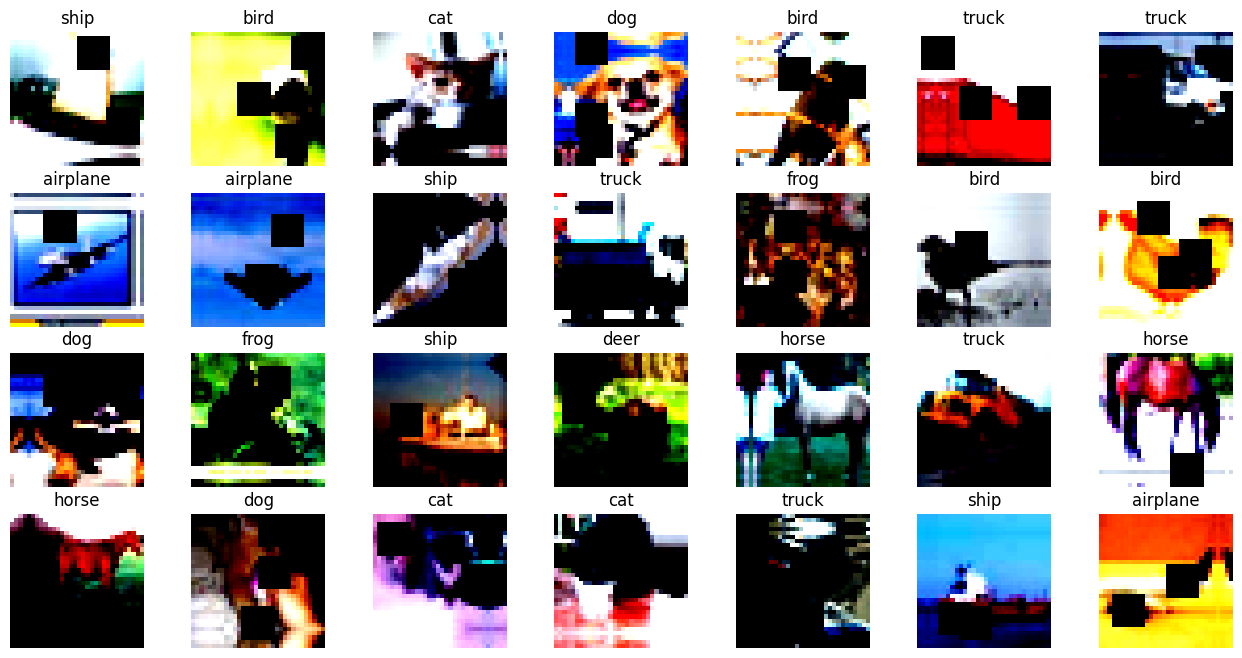

In [23]:
from utils.plot_utils import show_batch

show_batch(train_loader, labels)

In [15]:
device = get_default_device()
device

device(type='cuda')

In [16]:
import torch

In [17]:
from models.custom_resnet import CustomResNetClass, CustomResNet
from  models.resnet import ResNet

from utils.helper import model_summary
from utils.transforms import CIFAR10DataModule

# model = CustomResNet("BN").to(device)
model = CustomResNetClass()
epochs = 24
lr = 0.001
l1_factor = 0
max_epoch = 5

  0%|          | 0/1896 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.51E-01


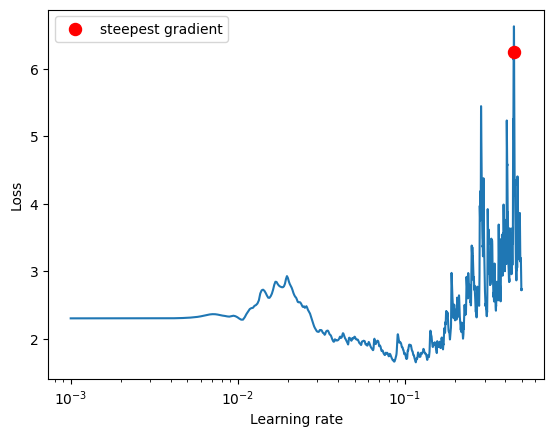

In [26]:
from utils.lr_finder import find_lr
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

optimizer = optim.SGD(model.parameters(), lr=lr,momentum=0.9, weight_decay = 0.005)
criterion = nn.CrossEntropyLoss()

max_lr = find_lr(model, train_loader, test_loader, epochs, optimizer, criterion, device)

In [18]:
max_lr = 0.04918839050131926

In [19]:
if max_epoch is None:
  div_factor = 25
  pct_start = 0.3
else:
  div_factor = 8
  pct_start = max_epoch / epochs


In [20]:
cifar10_dm = CIFAR10DataModule(batch_size=128)
len(cifar10_dm.test_dataloader())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


79

In [21]:
steps_per_epoch = len(cifar10_dm.train_dataloader())
steps_per_epoch

391

In [22]:
# Training function using PyTorch Lightning Trainer
from pytorch_lightning.loggers import TensorBoardLogger
save_dir ="/content/ERA-V1/Session12"

def train_custom_resnet(max_lr=max_lr,
                        div_factor=div_factor, pct_start=pct_start):


  cifar10_dm = CIFAR10DataModule(batch_size=128)
  steps_per_epoch = len(cifar10_dm.train_dataloader())
  model = CustomResNetClass(max_lr=max_lr,
                            div_factor=div_factor, pct_start=pct_start,
                            steps_per_epoch=steps_per_epoch)
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model = model.to(device)
  # Define callbacks
  early_stopping = EarlyStopping(monitor='val_loss', patience=3, mode='min')
  model_checkpoint = ModelCheckpoint(monitor='val_loss', filename='best_model', save_top_k=1, mode='min')


  logger = TensorBoardLogger(save_dir=save_dir, name="my_model")
  trainer = pl.Trainer(max_epochs=24, accelerator="auto", callbacks=[early_stopping, model_checkpoint])  # Set the number of epochs and the number of GPUs (if available)

  model_summary(model, (3, 32, 32))

  return cifar10_dm, trainer, model


cifar10_dm, trainer, model = train_custom_resnet(max_lr=max_lr,
                        div_factor=div_factor, pct_start=pct_start)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [23]:
trainer.fit(model, cifar10_dm)

Files already downloaded and verified
Files already downloaded and verified


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type               | Params
-------------------------------------------------
0 | conv1     | Conv2d             | 1.7 K 
1 | bn1       | BatchNorm2d        | 128   
2 | layer1    | Sequential         | 147 K 
3 | layer2    | Sequential         | 525 K 
4 | layer3    | Sequential         | 2.1 M 
5 | layer4    | Sequential         | 8.4 M 
6 | linear    | Linear             | 5.1 K 
7 | train_acc | MulticlassAccuracy | 0     
-------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.696    Total estimated model params size (MB)


details 391 0.04918839050131926 8 0.20833333333333334


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=24` reached.


In [ ]:
# Test the model after training
trainer.test(model, test_dataloaders=cifar10_dm.test_dataloader())

In [ ]:
from utils.plot_utils import misclassified_images

images_misclassified = misclassified_images(model, test_loader, device)

In [ ]:
from utils.plot_utils import plot_metrics

plot_metrics((train_accuracy, train_losses, test_accuracy, test_losses))

In [ ]:
from utils.helper import class_level_accuracy

class_level_accuracy(model, test_loader, device, labels)

In [ ]:
# Display the names of each layer in the convolutional network
for name, layer in model.named_children():
    print(name, layer)

In [ ]:
from utils.grad_cam import generate_gradcam, plot_gradcam

target_layers = ["layer2.1.conv2", "layer4.1.conv2", "layer3.1.conv2"]
gradcam_output, probs, predicted_classes = generate_gradcam_images(images_misclassified[:10], model, target_layers, device)
plot_gradcam(gradcam_output, target_layers, labels, (3, 32, 32), predicted_classes, images_misclassified[:10])